In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import scvelo as scv
import scipy as sp
from scipy import special
from scipy.stats import poisson,norm
from scipy.special import j_roots
from scipy.special import beta as beta_fun 
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
scv.set_figure_params(dpi=100, color_map = 'viridis_r')
scv.settings.verbosity = 1
sc.logging.print_header()

scanpy==1.7.2 anndata==0.8.0 umap==0.4.1 numpy==1.19.5 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9


In [3]:
# read UMI counts and params for c57 and cast viariants
UMI_c57 = pd.read_csv('data_arme/F1_ref/umiSplit_c57.qc.csv', index_col=0)
params_c57 = pd.read_csv('data_arme/F1_ref/umiSplit_c57.qc.maxl.ci.wfilt1.csv', index_col=0, header=None)
UMI_cast = pd.read_csv('data_arme/F1_ref/umiSplit_cast.qc.csv', index_col=0)
params_cast = pd.read_csv('data_arme/F1_ref/umiSplit_cast.qc.maxl.ci.wfilt1.csv', index_col=0, header=None)

In [4]:
UMI_c57.head(5)

GCTTAGAGAAGACC  GCTTAGGTAAGTGG  GCTTAGTCCGTGTT  \
ENSMUSG00000000001            15.0             4.0            11.0   
ENSMUSG00000000028             0.0             0.0             0.0   
ENSMUSG00000000037             0.0             0.0             0.0   
ENSMUSG00000000049             0.0             2.0             0.0   
ENSMUSG00000000056             1.0             1.0             0.0   

                    GTTGGAGTCTATTA  GTTGGAGAAGGCGT  GGATTCAGGTAGTG  \
ENSMUSG00000000001            13.0            20.0            17.0   
ENSMUSG00000000028             0.0             2.0             0.0   
ENSMUSG00000000037             1.0             0.0             0.0   
ENSMUSG00000000049             0.0             0.0             0.0   
ENSMUSG00000000056             NaN             0.0             0.0   

                    ATGCCGGATGTCCT  ACGGTCGTTGTCTG  ACGAGTGCGATGAT  \
ENSMUSG00000000001            26.0             6.0            18.0   
ENSMUSG00000000028             3.0             0.0             0.0   
ENSMUSG00000000037             0.0             0.0             NaN   
ENSMUSG00000000049             0.0             0.0             0.0   
ENSMUSG00000000056             0.0             0.0             0.0   

                    GCTTAGTACGACAC  ...  GCGGTTTTGACCTA  CACTGTGACGTCCA  \
ENSMUSG00000000001             3.0  ...            13.0             4.0   
ENSMUSG00000000028             NaN  ...             2.0             NaN   
ENSMUSG00000000037             0.0  ...             2.0             0.0   
ENSMUSG00000000049             0.0  ...             0.0             0.0   
ENSMUSG00000000056             1.0  ...             1.0             0.0   

                    GCGGTTGTCAAGAC  GGATCACGGTGCTT  GCGGTTGTACAACG  \
ENSMUSG00000000001             7.0            10.0            16.0   
ENSMUSG00000000028             0.0             NaN             0.0   
ENSMUSG00000000037             0.0             0.0             0.0   
ENSMUSG00000000049             0.0             0.0             0.0   
ENSMUSG00000000056             0.0             0.0             NaN   

                    GCGGTTAATCACGA  GCGGTTCTTCATCC  GCGGTTCATGAGTA  \
ENSMUSG00000000001            12.0             9.0             8.0   
ENSMUSG00000000028             3.0            13.0             0.0   
ENSMUSG00000000037             0.0             0.0             0.0   
ENSMUSG00000000049             0.0             0.0             0.0   
ENSMUSG00000000056             0.0             0.0             0.0   

                    GCGGTTAACCAGAG  GCGGTTCACCGTCT  
ENSMUSG00000000001             9.0            14.0  
ENSMUSG00000000028             0.0            12.0  
ENSMUSG00000000037             0.0             0.0  
ENSMUSG00000000049             0.0             0.0  
ENSMUSG00000000056             2.0             0.0  

[5 rows x 682 columns]

In [5]:
# sum the UMI counts into a single dataframe
UMI = UMI_c57 + UMI_cast

In [6]:
UMI.head(5)

GCTTAGAGAAGACC  GCTTAGGTAAGTGG  GCTTAGTCCGTGTT  \
ENSMUSG00000000001            21.0            16.0            35.0   
ENSMUSG00000000028             0.0             0.0             0.0   
ENSMUSG00000000037             0.0             0.0             0.0   
ENSMUSG00000000049             0.0             2.0             0.0   
ENSMUSG00000000056             1.0             3.0             4.0   

                    GTTGGAGTCTATTA  GTTGGAGAAGGCGT  GGATTCAGGTAGTG  \
ENSMUSG00000000001            30.0            35.0            46.0   
ENSMUSG00000000028             5.0             2.0             0.0   
ENSMUSG00000000037             1.0             0.0             0.0   
ENSMUSG00000000049             0.0             0.0             0.0   
ENSMUSG00000000056             NaN             1.0             2.0   

                    ATGCCGGATGTCCT  ACGGTCGTTGTCTG  ACGAGTGCGATGAT  \
ENSMUSG00000000001            63.0            23.0            38.0   
ENSMUSG00000000028             3.0             1.0             0.0   
ENSMUSG00000000037             0.0             0.0             NaN   
ENSMUSG00000000049             0.0             0.0             0.0   
ENSMUSG00000000056             0.0             0.0             0.0   

                    GCTTAGTACGACAC  ...  GCGGTTTTGACCTA  CACTGTGACGTCCA  \
ENSMUSG00000000001             9.0  ...            26.0            14.0   
ENSMUSG00000000028             NaN  ...             2.0             NaN   
ENSMUSG00000000037             0.0  ...             2.0             0.0   
ENSMUSG00000000049             0.0  ...             0.0             0.0   
ENSMUSG00000000056             2.0  ...             2.0             0.0   

                    GCGGTTGTCAAGAC  GGATCACGGTGCTT  GCGGTTGTACAACG  \
ENSMUSG00000000001            15.0            22.0            26.0   
ENSMUSG00000000028             0.0             NaN             0.0   
ENSMUSG00000000037             0.0             0.0             0.0   
ENSMUSG00000000049             0.0             0.0             0.0   
ENSMUSG00000000056             1.0             1.0             NaN   

                    GCGGTTAATCACGA  GCGGTTCTTCATCC  GCGGTTCATGAGTA  \
ENSMUSG00000000001            25.0            20.0            14.0   
ENSMUSG00000000028             4.0            15.0             0.0   
ENSMUSG00000000037             0.0             0.0             0.0   
ENSMUSG00000000049             0.0             0.0             0.0   
ENSMUSG00000000056             0.0             0.0             2.0   

                    GCGGTTAACCAGAG  GCGGTTCACCGTCT  
ENSMUSG00000000001            16.0            24.0  
ENSMUSG00000000028             0.0            15.0  
ENSMUSG00000000037             0.0             0.0  
ENSMUSG00000000049             0.0             0.0  
ENSMUSG00000000056             2.0             1.0  

[5 rows x 682 columns]

In [7]:
# transpose to ge n_cells x n_genes shape
UMI_c57_T = UMI_c57.transpose(copy=True)
UMI_cast_T = UMI_cast.transpose(copy=True)
UMI_T = UMI.transpose(copy=True)

In [8]:
UMI_T.head(5)

ENSMUSG00000000001  ENSMUSG00000000028  ENSMUSG00000000037  \
GCTTAGAGAAGACC                21.0                 0.0                 0.0   
GCTTAGGTAAGTGG                16.0                 0.0                 0.0   
GCTTAGTCCGTGTT                35.0                 0.0                 0.0   
GTTGGAGTCTATTA                30.0                 5.0                 1.0   
GTTGGAGAAGGCGT                35.0                 2.0                 0.0   

                ENSMUSG00000000049  ENSMUSG00000000056  ENSMUSG00000000058  \
GCTTAGAGAAGACC                 0.0                 1.0                11.0   
GCTTAGGTAAGTGG                 2.0                 3.0                 3.0   
GCTTAGTCCGTGTT                 0.0                 4.0                 NaN   
GTTGGAGTCTATTA                 0.0                 NaN                 3.0   
GTTGGAGAAGGCGT                 0.0                 1.0                 4.0   

                ENSMUSG00000000078  ENSMUSG00000000085  ENSMUSG00000000088  \
GCTTAGAGAAGACC                 7.0                 5.0                34.0   
GCTTAGGTAAGTGG                15.0                 7.0                14.0   
GCTTAGTCCGTGTT                 NaN                 NaN                23.0   
GTTGGAGTCTATTA                36.0                 0.0                18.0   
GTTGGAGAAGGCGT                 9.0                 NaN                30.0   

                ENSMUSG00000000093  ...  ENSMUSG00000115141  \
GCTTAGAGAAGACC                 0.0  ...                 0.0   
GCTTAGGTAAGTGG                 0.0  ...                 0.0   
GCTTAGTCCGTGTT                 0.0  ...                 0.0   
GTTGGAGTCTATTA                 0.0  ...                 0.0   
GTTGGAGAAGGCGT                 0.0  ...                 0.0   

                ENSMUSG00000115347  ENSMUSG00000115367  ENSMUSG00000115454  \
GCTTAGAGAAGACC                 0.0                 0.0                 0.0   
GCTTAGGTAAGTGG                 0.0                 0.0                 0.0   
GCTTAGTCCGTGTT                 0.0                 0.0                 0.0   
GTTGGAGTCTATTA                 0.0                 0.0                 0.0   
GTTGGAGAAGGCGT                 0.0                 0.0                 0.0   

                ENSMUSG00000115526  ENSMUSG00000115595  ENSMUSG00000115637  \
GCTTAGAGAAGACC                 0.0                 0.0                 0.0   
GCTTAGGTAAGTGG                 0.0                 0.0                 0.0   
GCTTAGTCCGTGTT                 0.0                 0.0                 0.0   
GTTGGAGTCTATTA                 0.0                 0.0                 0.0   
GTTGGAGAAGGCGT                 0.0                 0.0                 0.0   

                ENSMUSG00000115643  ENSMUSG00000115725  ENSMUSG00000115811  
GCTTAGAGAAGACC                 0.0                 0.0                 0.0  
GCTTAGGTAAGTGG                 0.0                 0.0                 0.0  
GCTTAGTCCGTGTT                 0.0                 0.0                 0.0  
GTTGGAGTCTATTA                 0.0                 0.0                 0.0  
GTTGGAGAAGGCGT                 0.0                 0.0                 0.0  

[5 rows x 23270 columns]

In [9]:
# UMI_c57_T = UMI_c57_T.fillna(0)
# UMI_cast_T = UMI_cast_T.fillna(0)
# UMI_T = UMI_T.fillna(0)

# removing NA values from the dataframes 
UMI_c57_T = UMI_c57_T.dropna(axis=1)
UMI_cast_T = UMI_cast_T.dropna(axis=1)
UMI_T = UMI_T.dropna(axis=1)

In [10]:
common_cols1 = UMI_c57_T.columns.intersection(UMI_cast_T.columns)
common_cols2 = UMI_cast_T.columns.intersection(UMI_T.columns)
common_cols = common_cols1.intersection(common_cols2)
common_cols

Index(['ENSMUSG00000000001', 'ENSMUSG00000000049', 'ENSMUSG00000000088',
       'ENSMUSG00000000120', 'ENSMUSG00000000184', 'ENSMUSG00000000214',
       'ENSMUSG00000000295', 'ENSMUSG00000000303', 'ENSMUSG00000000326',
       'ENSMUSG00000000339',
       ...
       'ENSMUSG00000114686', 'ENSMUSG00000114828', 'ENSMUSG00000114922',
       'ENSMUSG00000114945', 'ENSMUSG00000115141', 'ENSMUSG00000115367',
       'ENSMUSG00000115454', 'ENSMUSG00000115526', 'ENSMUSG00000115643',
       'ENSMUSG00000115811'],
      dtype='object', length=5066)

In [11]:
UMI_c57_T = UMI_c57_T[common_cols]
UMI_cast_T = UMI_cast_T[common_cols]
UMI_T = UMI_T[common_cols]

In [12]:
UMI_c57_T = UMI_c57_T.reindex()
UMI_cast_T = UMI_cast_T.reindex()
UMI_T = UMI_T.reindex()

In [13]:
UMI_T.head()

ENSMUSG00000000001  ENSMUSG00000000049  ENSMUSG00000000088  \
GCTTAGAGAAGACC                21.0                 0.0                34.0   
GCTTAGGTAAGTGG                16.0                 2.0                14.0   
GCTTAGTCCGTGTT                35.0                 0.0                23.0   
GTTGGAGTCTATTA                30.0                 0.0                18.0   
GTTGGAGAAGGCGT                35.0                 0.0                30.0   

                ENSMUSG00000000120  ENSMUSG00000000184  ENSMUSG00000000214  \
GCTTAGAGAAGACC                 0.0               123.0                 0.0   
GCTTAGGTAAGTGG                 0.0                18.0                 0.0   
GCTTAGTCCGTGTT                 0.0               164.0                 0.0   
GTTGGAGTCTATTA                 0.0               157.0                 0.0   
GTTGGAGAAGGCGT                 0.0               171.0                 0.0   

                ENSMUSG00000000295  ENSMUSG00000000303  ENSMUSG00000000326  \
GCTTAGAGAAGACC                 3.0                 0.0                15.0   
GCTTAGGTAAGTGG                 2.0                 0.0                31.0   
GCTTAGTCCGTGTT                 9.0                 0.0                36.0   
GTTGGAGTCTATTA                15.0                 0.0                62.0   
GTTGGAGAAGGCGT                11.0                 0.0                48.0   

                ENSMUSG00000000339  ...  ENSMUSG00000114686  \
GCTTAGAGAAGACC                 5.0  ...                 0.0   
GCTTAGGTAAGTGG                 6.0  ...                 0.0   
GCTTAGTCCGTGTT                 9.0  ...                 0.0   
GTTGGAGTCTATTA                 8.0  ...                 0.0   
GTTGGAGAAGGCGT                13.0  ...                 0.0   

                ENSMUSG00000114828  ENSMUSG00000114922  ENSMUSG00000114945  \
GCTTAGAGAAGACC                 0.0                 0.0                 0.0   
GCTTAGGTAAGTGG                 0.0                 0.0                 0.0   
GCTTAGTCCGTGTT                 0.0                 0.0                 0.0   
GTTGGAGTCTATTA                 0.0                 0.0                 0.0   
GTTGGAGAAGGCGT                 0.0                 0.0                 0.0   

                ENSMUSG00000115141  ENSMUSG00000115367  ENSMUSG00000115454  \
GCTTAGAGAAGACC                 0.0                 0.0                 0.0   
GCTTAGGTAAGTGG                 0.0                 0.0                 0.0   
GCTTAGTCCGTGTT                 0.0                 0.0                 0.0   
GTTGGAGTCTATTA                 0.0                 0.0                 0.0   
GTTGGAGAAGGCGT                 0.0                 0.0                 0.0   

                ENSMUSG00000115526  ENSMUSG00000115643  ENSMUSG00000115811  
GCTTAGAGAAGACC                 0.0                 0.0                 0.0  
GCTTAGGTAAGTGG                 0.0                 0.0                 0.0  
GCTTAGTCCGTGTT                 0.0                 0.0                 0.0  
GTTGGAGTCTATTA                 0.0                 0.0                 0.0  
GTTGGAGAAGGCGT                 0.0                 0.0                 0.0  

[5 rows x 5066 columns]

In [14]:
# taking c57 UMI count sum over genes
UMI_c57_T_sum = UMI_c57_T.sum(axis=0)
UMI_c57_T_sum

ENSMUSG00000000001     8956.0
ENSMUSG00000000049       46.0
ENSMUSG00000000088     7514.0
ENSMUSG00000000120        0.0
ENSMUSG00000000184    36198.0
                       ...   
ENSMUSG00000115367        0.0
ENSMUSG00000115454        1.0
ENSMUSG00000115526        1.0
ENSMUSG00000115643        0.0
ENSMUSG00000115811        0.0
Length: 5066, dtype: float64

In [15]:
# taking cast UMI count sum over genes
UMI_cast_T_sum = UMI_cast_T.sum(axis=0)
UMI_cast_T_sum

ENSMUSG00000000001    10024.0
ENSMUSG00000000049       48.0
ENSMUSG00000000088     7028.0
ENSMUSG00000000120        4.0
ENSMUSG00000000184    33010.0
                       ...   
ENSMUSG00000115367        0.0
ENSMUSG00000115454        0.0
ENSMUSG00000115526        0.0
ENSMUSG00000115643        0.0
ENSMUSG00000115811        0.0
Length: 5066, dtype: float64

In [16]:
UMI_c57_ratio = UMI_c57_T_sum/(UMI_cast_T_sum + UMI_c57_T_sum)
UMI_c57_ratio

ENSMUSG00000000001    0.471865
ENSMUSG00000000049    0.489362
ENSMUSG00000000088    0.516710
ENSMUSG00000000120    0.000000
ENSMUSG00000000184    0.523032
                        ...   
ENSMUSG00000115367         NaN
ENSMUSG00000115454    1.000000
ENSMUSG00000115526    1.000000
ENSMUSG00000115643         NaN
ENSMUSG00000115811         NaN
Length: 5066, dtype: float64

In [17]:
UMI_c57_ratio = UMI_c57_ratio.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
UMI_c57_ratio

ENSMUSG00000000001    0.471865
ENSMUSG00000000049    0.489362
ENSMUSG00000000088    0.516710
ENSMUSG00000000120    0.000000
ENSMUSG00000000184    0.523032
                        ...   
ENSMUSG00000113877    1.000000
ENSMUSG00000114922    1.000000
ENSMUSG00000115141    1.000000
ENSMUSG00000115454    1.000000
ENSMUSG00000115526    1.000000
Length: 4070, dtype: float64

In [18]:
UMI_cast_ratio = UMI_cast_T_sum/(UMI_cast_T_sum + UMI_c57_T_sum)
UMI_cast_ratio

ENSMUSG00000000001    0.528135
ENSMUSG00000000049    0.510638
ENSMUSG00000000088    0.483290
ENSMUSG00000000120    1.000000
ENSMUSG00000000184    0.476968
                        ...   
ENSMUSG00000115367         NaN
ENSMUSG00000115454    0.000000
ENSMUSG00000115526    0.000000
ENSMUSG00000115643         NaN
ENSMUSG00000115811         NaN
Length: 5066, dtype: float64

In [19]:
UMI_cast_ratio = UMI_cast_ratio.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
UMI_cast_ratio

ENSMUSG00000000001    0.528135
ENSMUSG00000000049    0.510638
ENSMUSG00000000088    0.483290
ENSMUSG00000000120    1.000000
ENSMUSG00000000184    0.476968
                        ...   
ENSMUSG00000113877    0.000000
ENSMUSG00000114922    0.000000
ENSMUSG00000115141    0.000000
ENSMUSG00000115454    0.000000
ENSMUSG00000115526    0.000000
Length: 4070, dtype: float64

In [20]:
UMI_ratio_common = UMI_c57_ratio.index.intersection(UMI_cast_ratio.index)
UMI_ratio_common

Index(['ENSMUSG00000000001', 'ENSMUSG00000000049', 'ENSMUSG00000000088',
       'ENSMUSG00000000120', 'ENSMUSG00000000184', 'ENSMUSG00000000214',
       'ENSMUSG00000000295', 'ENSMUSG00000000303', 'ENSMUSG00000000326',
       'ENSMUSG00000000339',
       ...
       'ENSMUSG00000112404', 'ENSMUSG00000112500', 'ENSMUSG00000112873',
       'ENSMUSG00000112895', 'ENSMUSG00000113282', 'ENSMUSG00000113877',
       'ENSMUSG00000114922', 'ENSMUSG00000115141', 'ENSMUSG00000115454',
       'ENSMUSG00000115526'],
      dtype='object', length=4070)

Text(0.5, 0, 'ratio for C57')

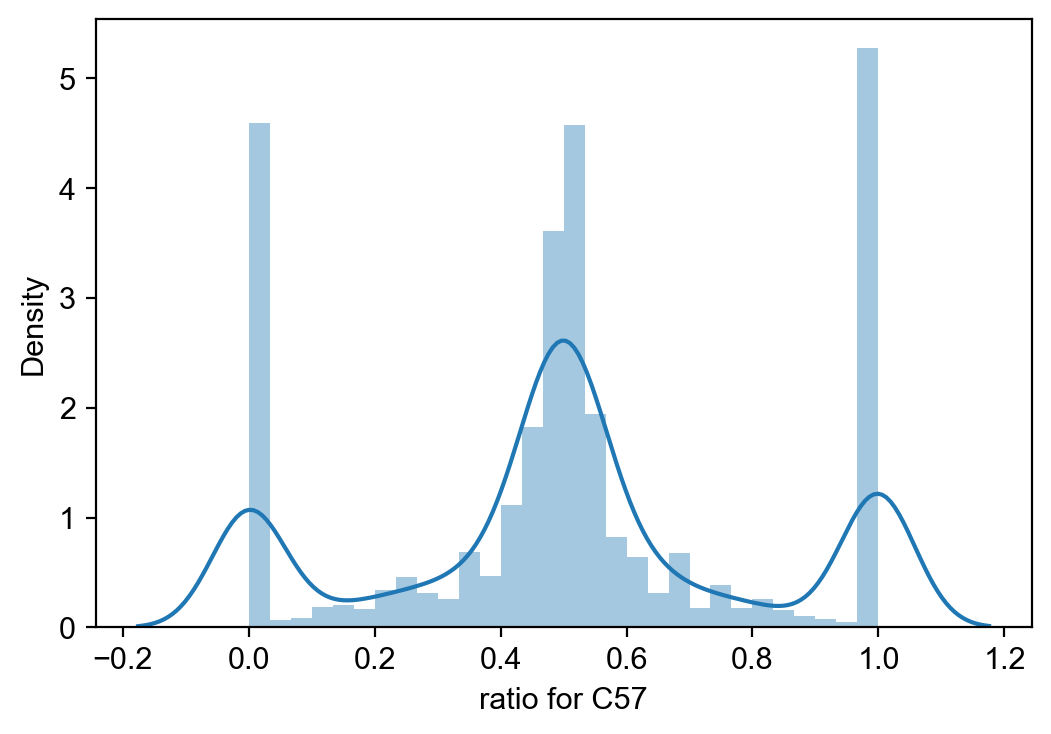

In [21]:
sns.distplot(UMI_c57_ratio)
plt.xlabel('ratio for C57')

Text(0.5, 0, 'ratio for CAST')

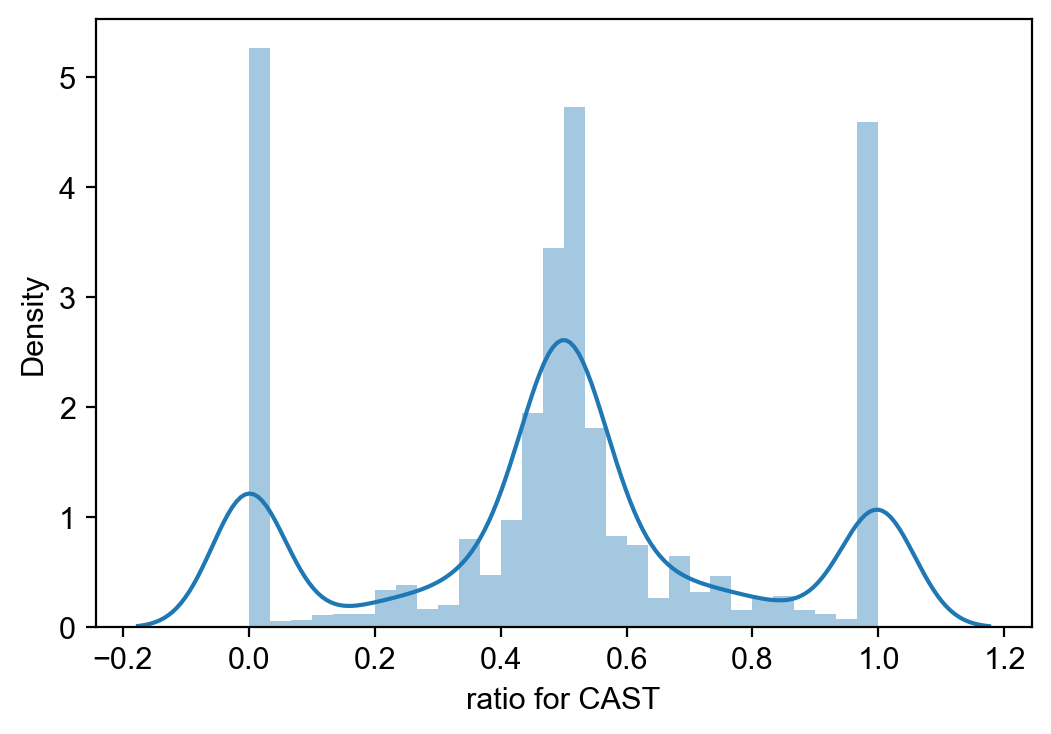

In [22]:
sns.distplot(UMI_cast_ratio)
plt.xlabel('ratio for CAST')

In [23]:
df = pd.DataFrame(
    {
        "sum_c57": UMI_c57_T_sum[UMI_ratio_common],
        "sum_cast": UMI_cast_T_sum[UMI_ratio_common],
        "ratio_c57": UMI_c57_ratio[UMI_ratio_common],
        "ratio_cast": UMI_cast_ratio[UMI_ratio_common]
    },
    index=UMI_ratio_common,
)
df.head()

sum_c57  sum_cast  ratio_c57  ratio_cast
ENSMUSG00000000001   8956.0   10024.0   0.471865    0.528135
ENSMUSG00000000049     46.0      48.0   0.489362    0.510638
ENSMUSG00000000088   7514.0    7028.0   0.516710    0.483290
ENSMUSG00000000120      0.0       4.0   0.000000    1.000000
ENSMUSG00000000184  36198.0   33010.0   0.523032    0.476968

In [24]:
df[(df['sum_c57'] == 0.0) | (df['sum_cast'] == 0.0)]

sum_c57  sum_cast  ratio_c57  ratio_cast
ENSMUSG00000000120      0.0       4.0        0.0         1.0
ENSMUSG00000000214      0.0       1.0        0.0         1.0
ENSMUSG00000001103      0.0       1.0        0.0         1.0
ENSMUSG00000001155      0.0       1.0        0.0         1.0
ENSMUSG00000002100      1.0       0.0        1.0         0.0
...                     ...       ...        ...         ...
ENSMUSG00000113877      1.0       0.0        1.0         0.0
ENSMUSG00000114922      2.0       0.0        1.0         0.0
ENSMUSG00000115141      2.0       0.0        1.0         0.0
ENSMUSG00000115454      1.0       0.0        1.0         0.0
ENSMUSG00000115526      1.0       0.0        1.0         0.0

[1292 rows x 4 columns]

<AxesSubplot:xlabel='ratio_c57', ylabel='sum_c57'>

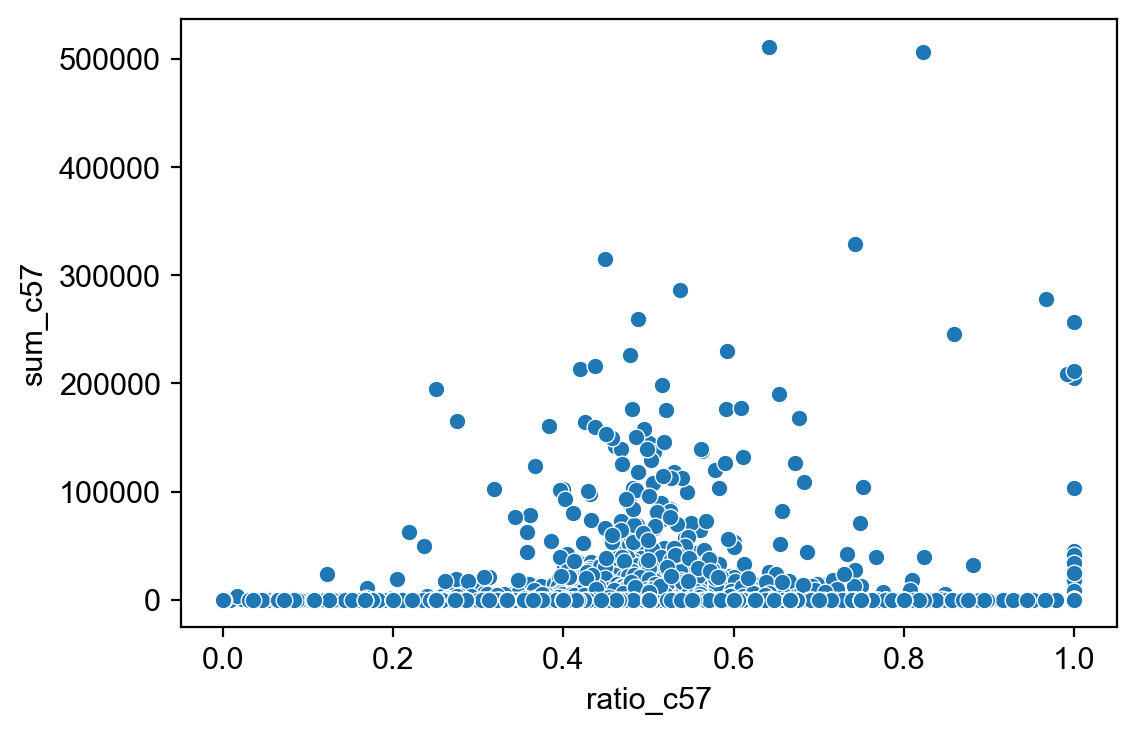

In [62]:
sns.scatterplot(data=df, x="ratio_c57", y="sum_c57")

<AxesSubplot:xlabel='ratio_c57', ylabel='sum_cast'>

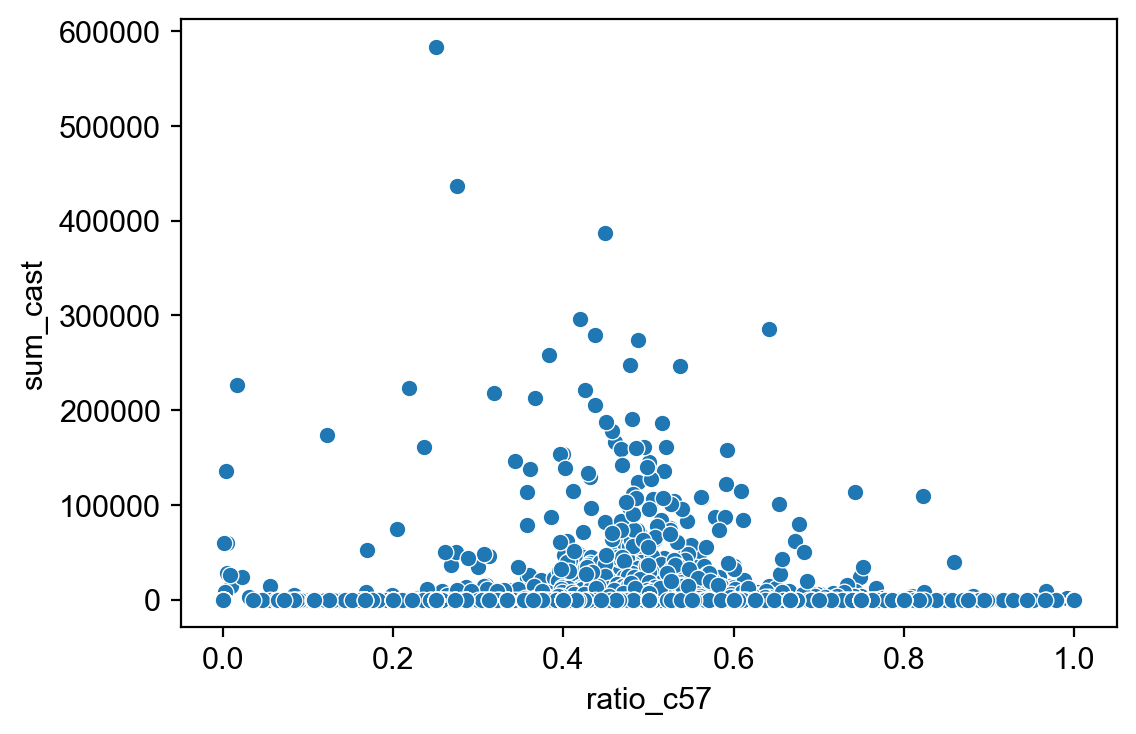

In [63]:
sns.scatterplot(data=df, x="ratio_c57", y="sum_cast")

In [26]:
df_test = df[(df['ratio_cast'] < 0.1) & (df['sum_c57'] > 200000)]
df_test

sum_c57  sum_cast  ratio_c57  ratio_cast
ENSMUSG00000001131  205319.0      32.0   0.999844    0.000156
ENSMUSG00000008682  209026.0    1737.0   0.991759    0.008241
ENSMUSG00000031320  211622.0      64.0   0.999698    0.000302
ENSMUSG00000031375  256737.0      85.0   0.999669    0.000331
ENSMUSG00000044533  278432.0    9473.0   0.967097    0.032903

<AxesSubplot:xlabel='ratio_cast', ylabel='sum_c57'>

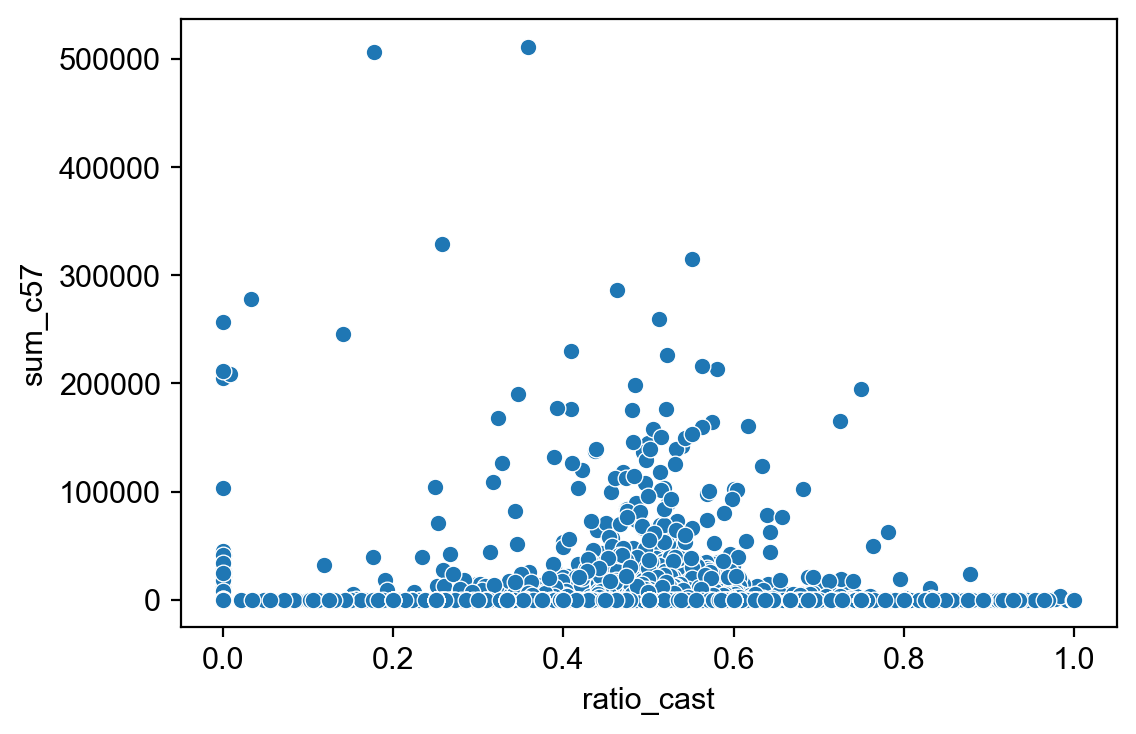

In [64]:
sns.scatterplot(data=df, x="ratio_cast", y="sum_c57")

<AxesSubplot:xlabel='ratio_cast', ylabel='sum_cast'>

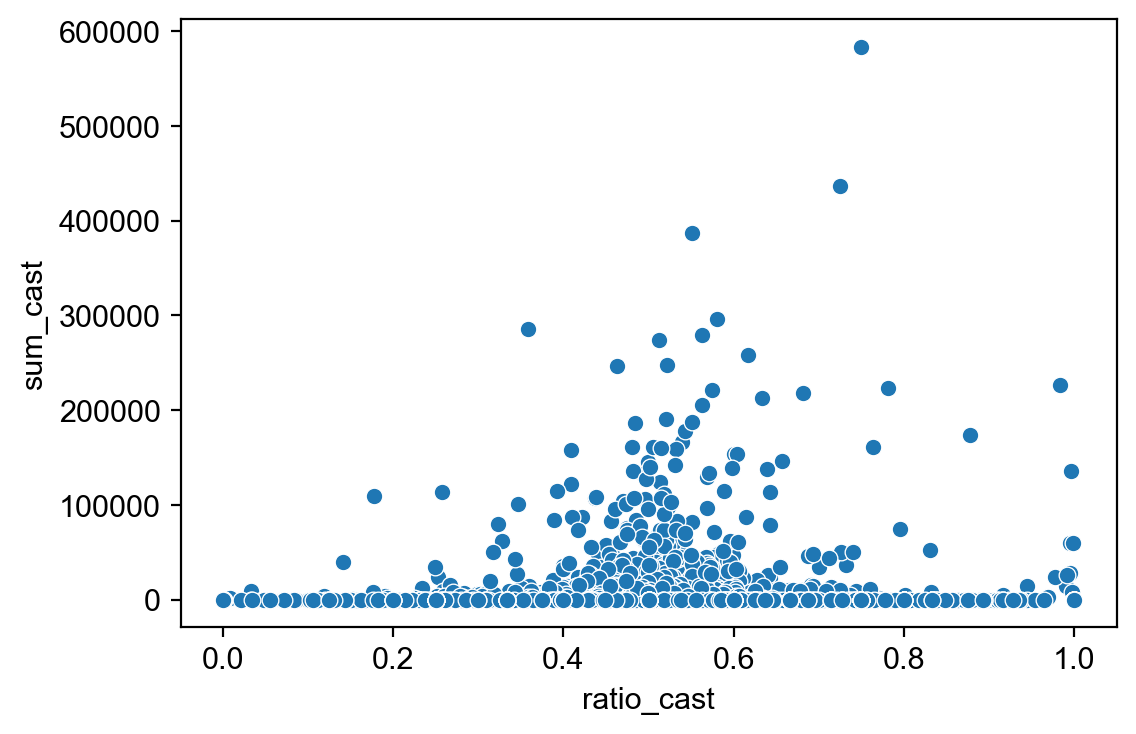

In [65]:
sns.scatterplot(data=df, x="ratio_cast", y="sum_cast")

In [28]:
df_test2 = df[(df['ratio_cast'] > 0.9) & (df['sum_cast'] > 100000)]
df_test2

sum_c57  sum_cast  ratio_c57  ratio_cast
ENSMUSG00000081094    474.0  136377.0   0.003464    0.996536
ENSMUSG00000098178   3849.0  226188.0   0.016732    0.983268

In [29]:
# UMI_ratio2 = UMI_ratio[((UMI_ratio.values > 2) | (UMI_ratio.values < 0.5))]
# UMI_ratio2

In [30]:
# UMI_ratio2 = UMI_ratio2[UMI_ratio2.values != 0.0]
# UMI_ratio2

In [31]:
# UMI_c57_T = UMI_c57_T[UMI_ratio_common]
# UMI_cast_T = UMI_cast_T[UMI_ratio_common]
# UMI_T = UMI_T[UMI_ratio_common]

In [32]:
adata = ad.AnnData(UMI_T)
adata

AnnData object with n_obs × n_vars = 682 × 5066

In [33]:
adata.layers['spliced'] = UMI_c57_T
adata.layers['unspliced'] = UMI_cast_T

In [34]:
adata.var_names_make_unique() 

In [35]:
sc.pp.neighbors(adata, n_neighbors=8, n_pcs=31)
sc.tl.umap(adata)
sc.tl.leiden(adata)
adata.obs['clusters'] = adata.obs['leiden'].copy()

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [36]:
adata

AnnData object with n_obs × n_vars = 682 × 5066
    obs: 'leiden', 'clusters'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [37]:
count = 1
for x in df_test.index:
    if x in adata.var.index:
        scv.pl.scatter(adata, x, color=['clusters'], save=f"data/UMI_ratio_figures/fig_{x}.pdf", 
                       xlabel='C57', ylabel='CAST', title=f"{x} (Raw UMI counts)",
                       show=False)
        count += 1

saving figure to file data/UMI_ratio_figures/fig_ENSMUSG00000001131.pdf
saving figure to file data/UMI_ratio_figures/fig_ENSMUSG00000008682.pdf
saving figure to file data/UMI_ratio_figures/fig_ENSMUSG00000031320.pdf
saving figure to file data/UMI_ratio_figures/fig_ENSMUSG00000031375.pdf
saving figure to file data/UMI_ratio_figures/fig_ENSMUSG00000044533.pdf


In [38]:
count = 1
for x in df_test2.index:
    if x in adata.var.index:
        scv.pl.scatter(adata, x, color=['clusters'], save=f"data/UMI_ratio_figures/fig_{x}.pdf", 
                       xlabel='C57', ylabel='CAST', title=f"{x} (Raw UMI counts)",
                       show=False)
        count += 1

saving figure to file data/UMI_ratio_figures/fig_ENSMUSG00000081094.pdf
saving figure to file data/UMI_ratio_figures/fig_ENSMUSG00000098178.pdf


In [39]:
scv.pp.filter_and_normalize(adata, min_shared_counts=1, n_top_genes=20000)
scv.pp.moments(adata, n_pcs=31, n_neighbors=8)
adata

AnnData object with n_obs × n_vars = 682 × 1953
    obs: 'leiden', 'clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    uns: 'neighbors', 'umap', 'leiden', 'clusters_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [40]:
scv.tl.recover_dynamics(adata, n_jobs = 8)

  0%|          | 0/749 [00:00<?, ?gene/s]

In [41]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

  0%|          | 0/682 [00:00<?, ?cells/s]

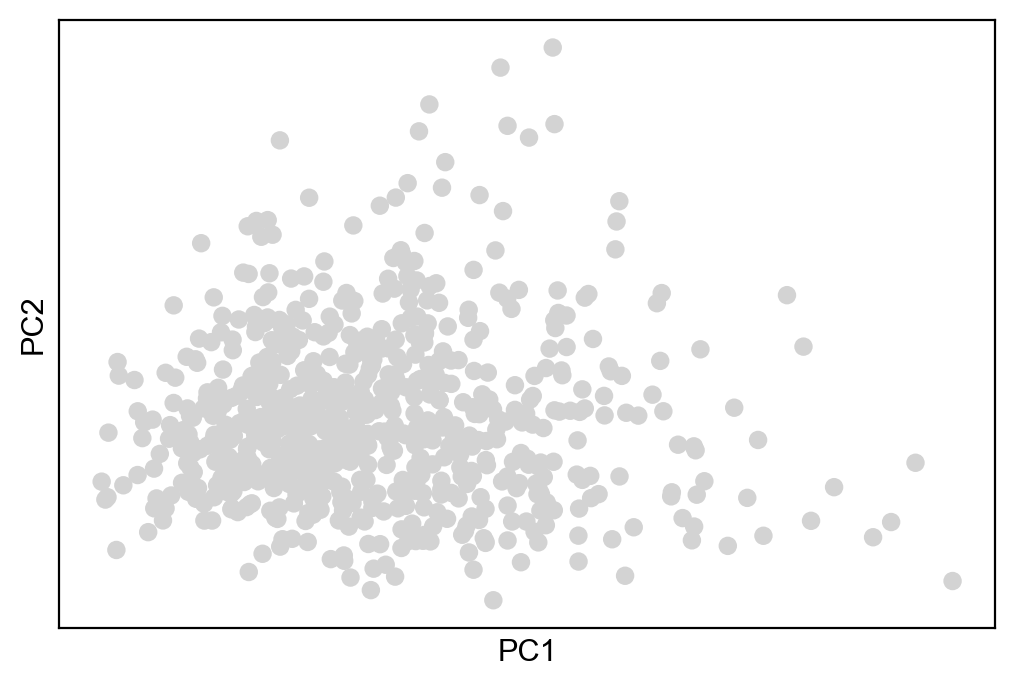

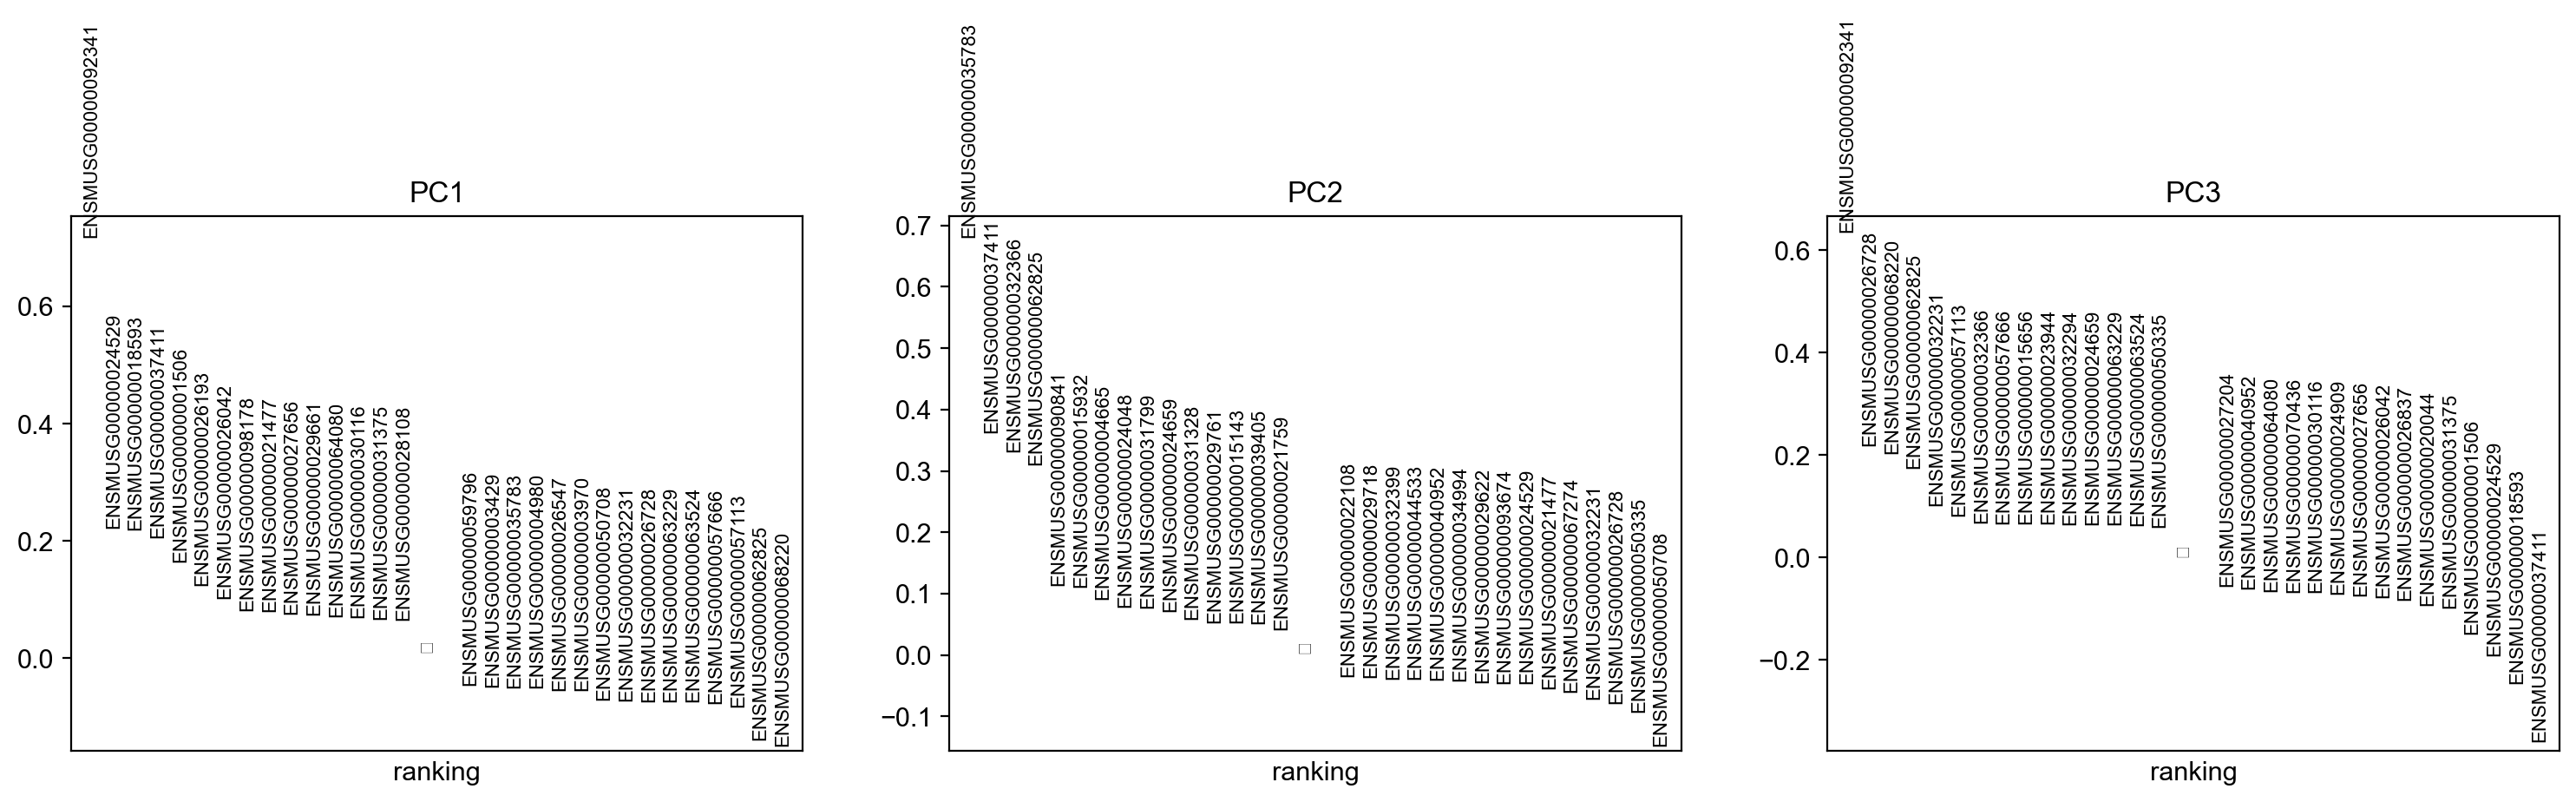

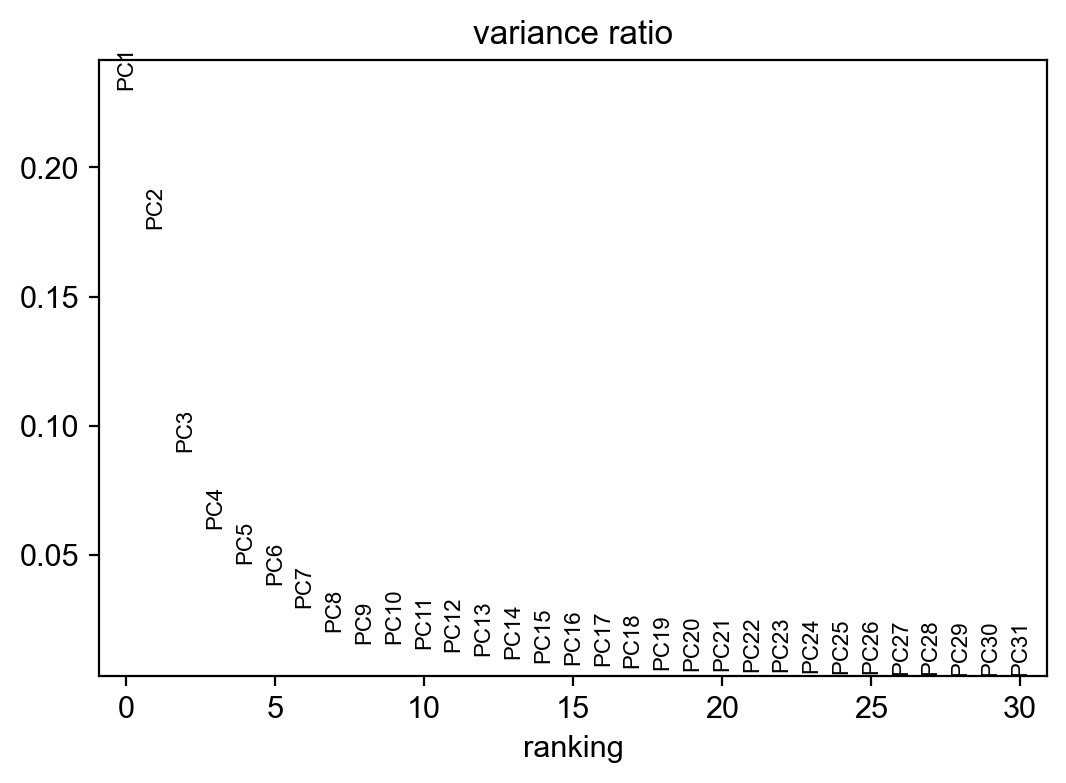

In [42]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_overview(adata)

In [43]:
sc.pp.neighbors(adata, n_neighbors=8, n_pcs=31)

In [44]:
sc.tl.umap(adata)

In [45]:
sc.tl.leiden(adata)

In [46]:
adata.obs['clusters'] = adata.obs['leiden'].copy()

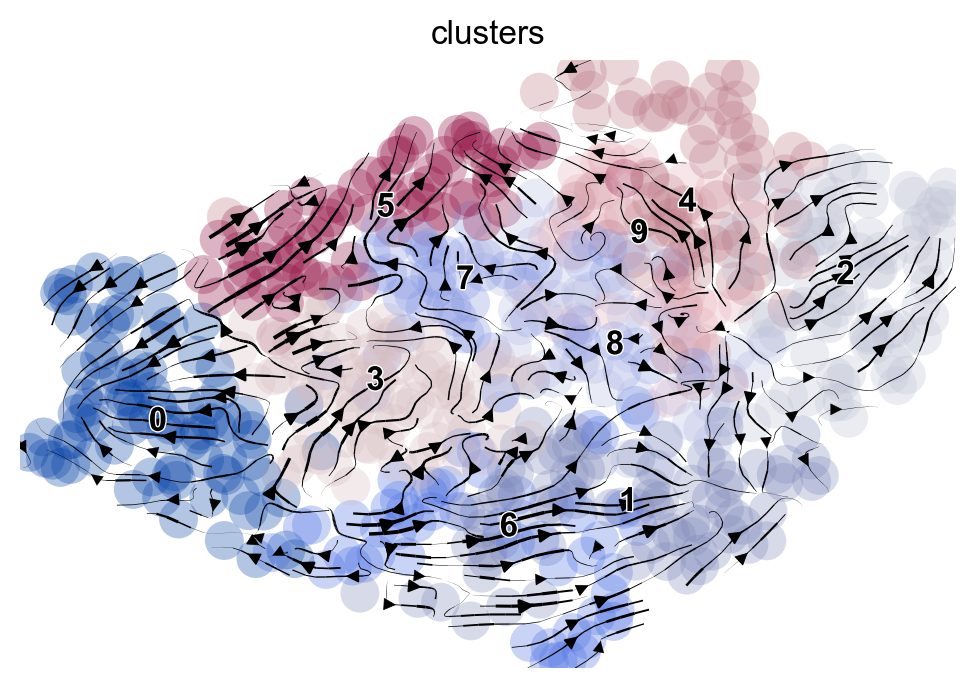

In [47]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

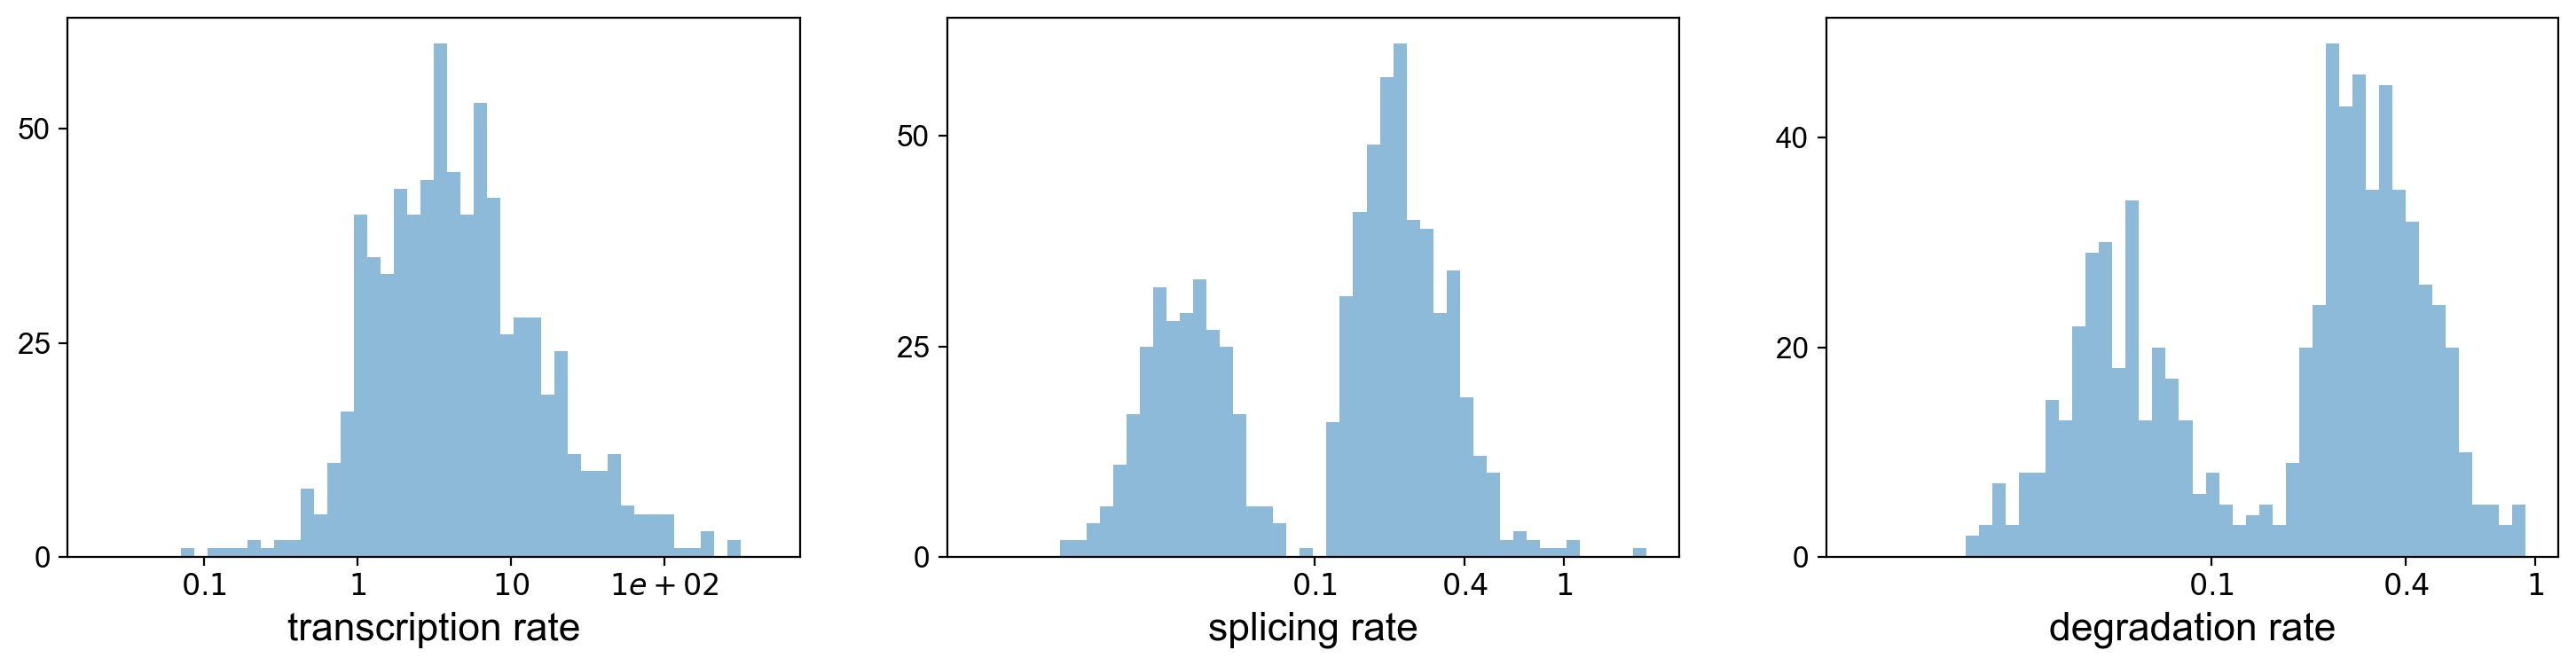

fit_r2  fit_alpha  fit_beta  fit_gamma      fit_t_  \
ENSMUSG00000000184  0.699847  24.034698  0.317861   0.271710   12.521677   
ENSMUSG00000000563  0.021722  13.034601  0.305566   0.317815   19.390246   
ENSMUSG00000000693  0.471829   2.676078  0.077450   0.079255   41.356722   
ENSMUSG00000000740  0.500676   5.229308  0.013949   0.018491  206.992221   
ENSMUSG00000000753  0.735184  15.257214  0.140295   0.108618   35.460329   

                    fit_scaling  fit_std_u  fit_std_s  fit_likelihood  fit_u0  \
ENSMUSG00000000184     0.440396  13.306070  14.049442        0.265410     0.0   
ENSMUSG00000000563     1.225313   4.148489   4.489758        0.188671     0.0   
ENSMUSG00000000693     0.621621   5.529958   4.826094        0.254615     0.0   
ENSMUSG00000000740     0.975037  24.143370  19.499681        0.241191     0.0   
ENSMUSG00000000753     0.365616  17.172886  22.193184        0.280108     0.0   

                    fit_s0  fit_pval_steady  fit_steady_u  fit_steady_s  \
ENSMUSG00000000184     0.0         0.495828     49.769141     55.425437   
ENSMUSG00000000563     0.0         0.491407     44.629250     40.151667   
ENSMUSG00000000693     0.0         0.484248     26.446457     23.557581   
ENSMUSG00000000740     0.0         0.497514    327.605927    239.341933   
ENSMUSG00000000753     0.0         0.497627     78.822430     96.505064   

                    fit_variance  fit_alignment_scaling  
ENSMUSG00000000184      0.627188               3.053901  
ENSMUSG00000000563      1.198264               3.256203  
ENSMUSG00000000693      0.795928              10.731555  
ENSMUSG00000000740      0.994506              55.143607  
ENSMUSG00000000753      0.656804               8.772931

In [48]:
# kinetic rate params
df2 = adata.var
df2 = df2[(df2['fit_likelihood'] > .1) & df2['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df2['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df2['fit_beta'] * df2['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df2['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(adata, 'fit*', dropna=True).head()

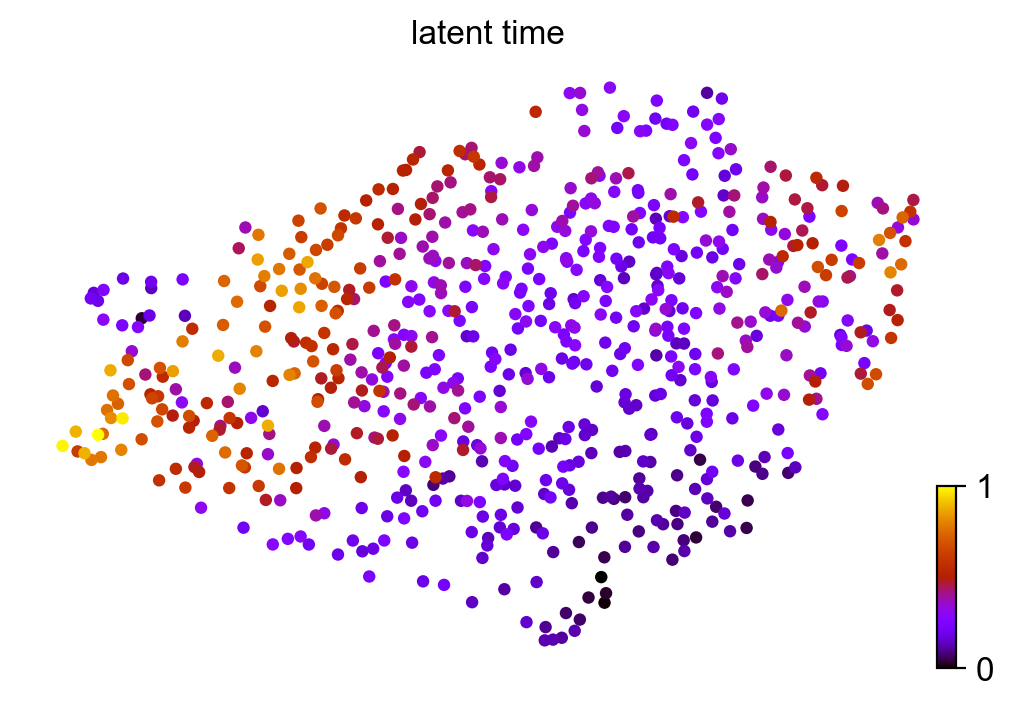

In [49]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)

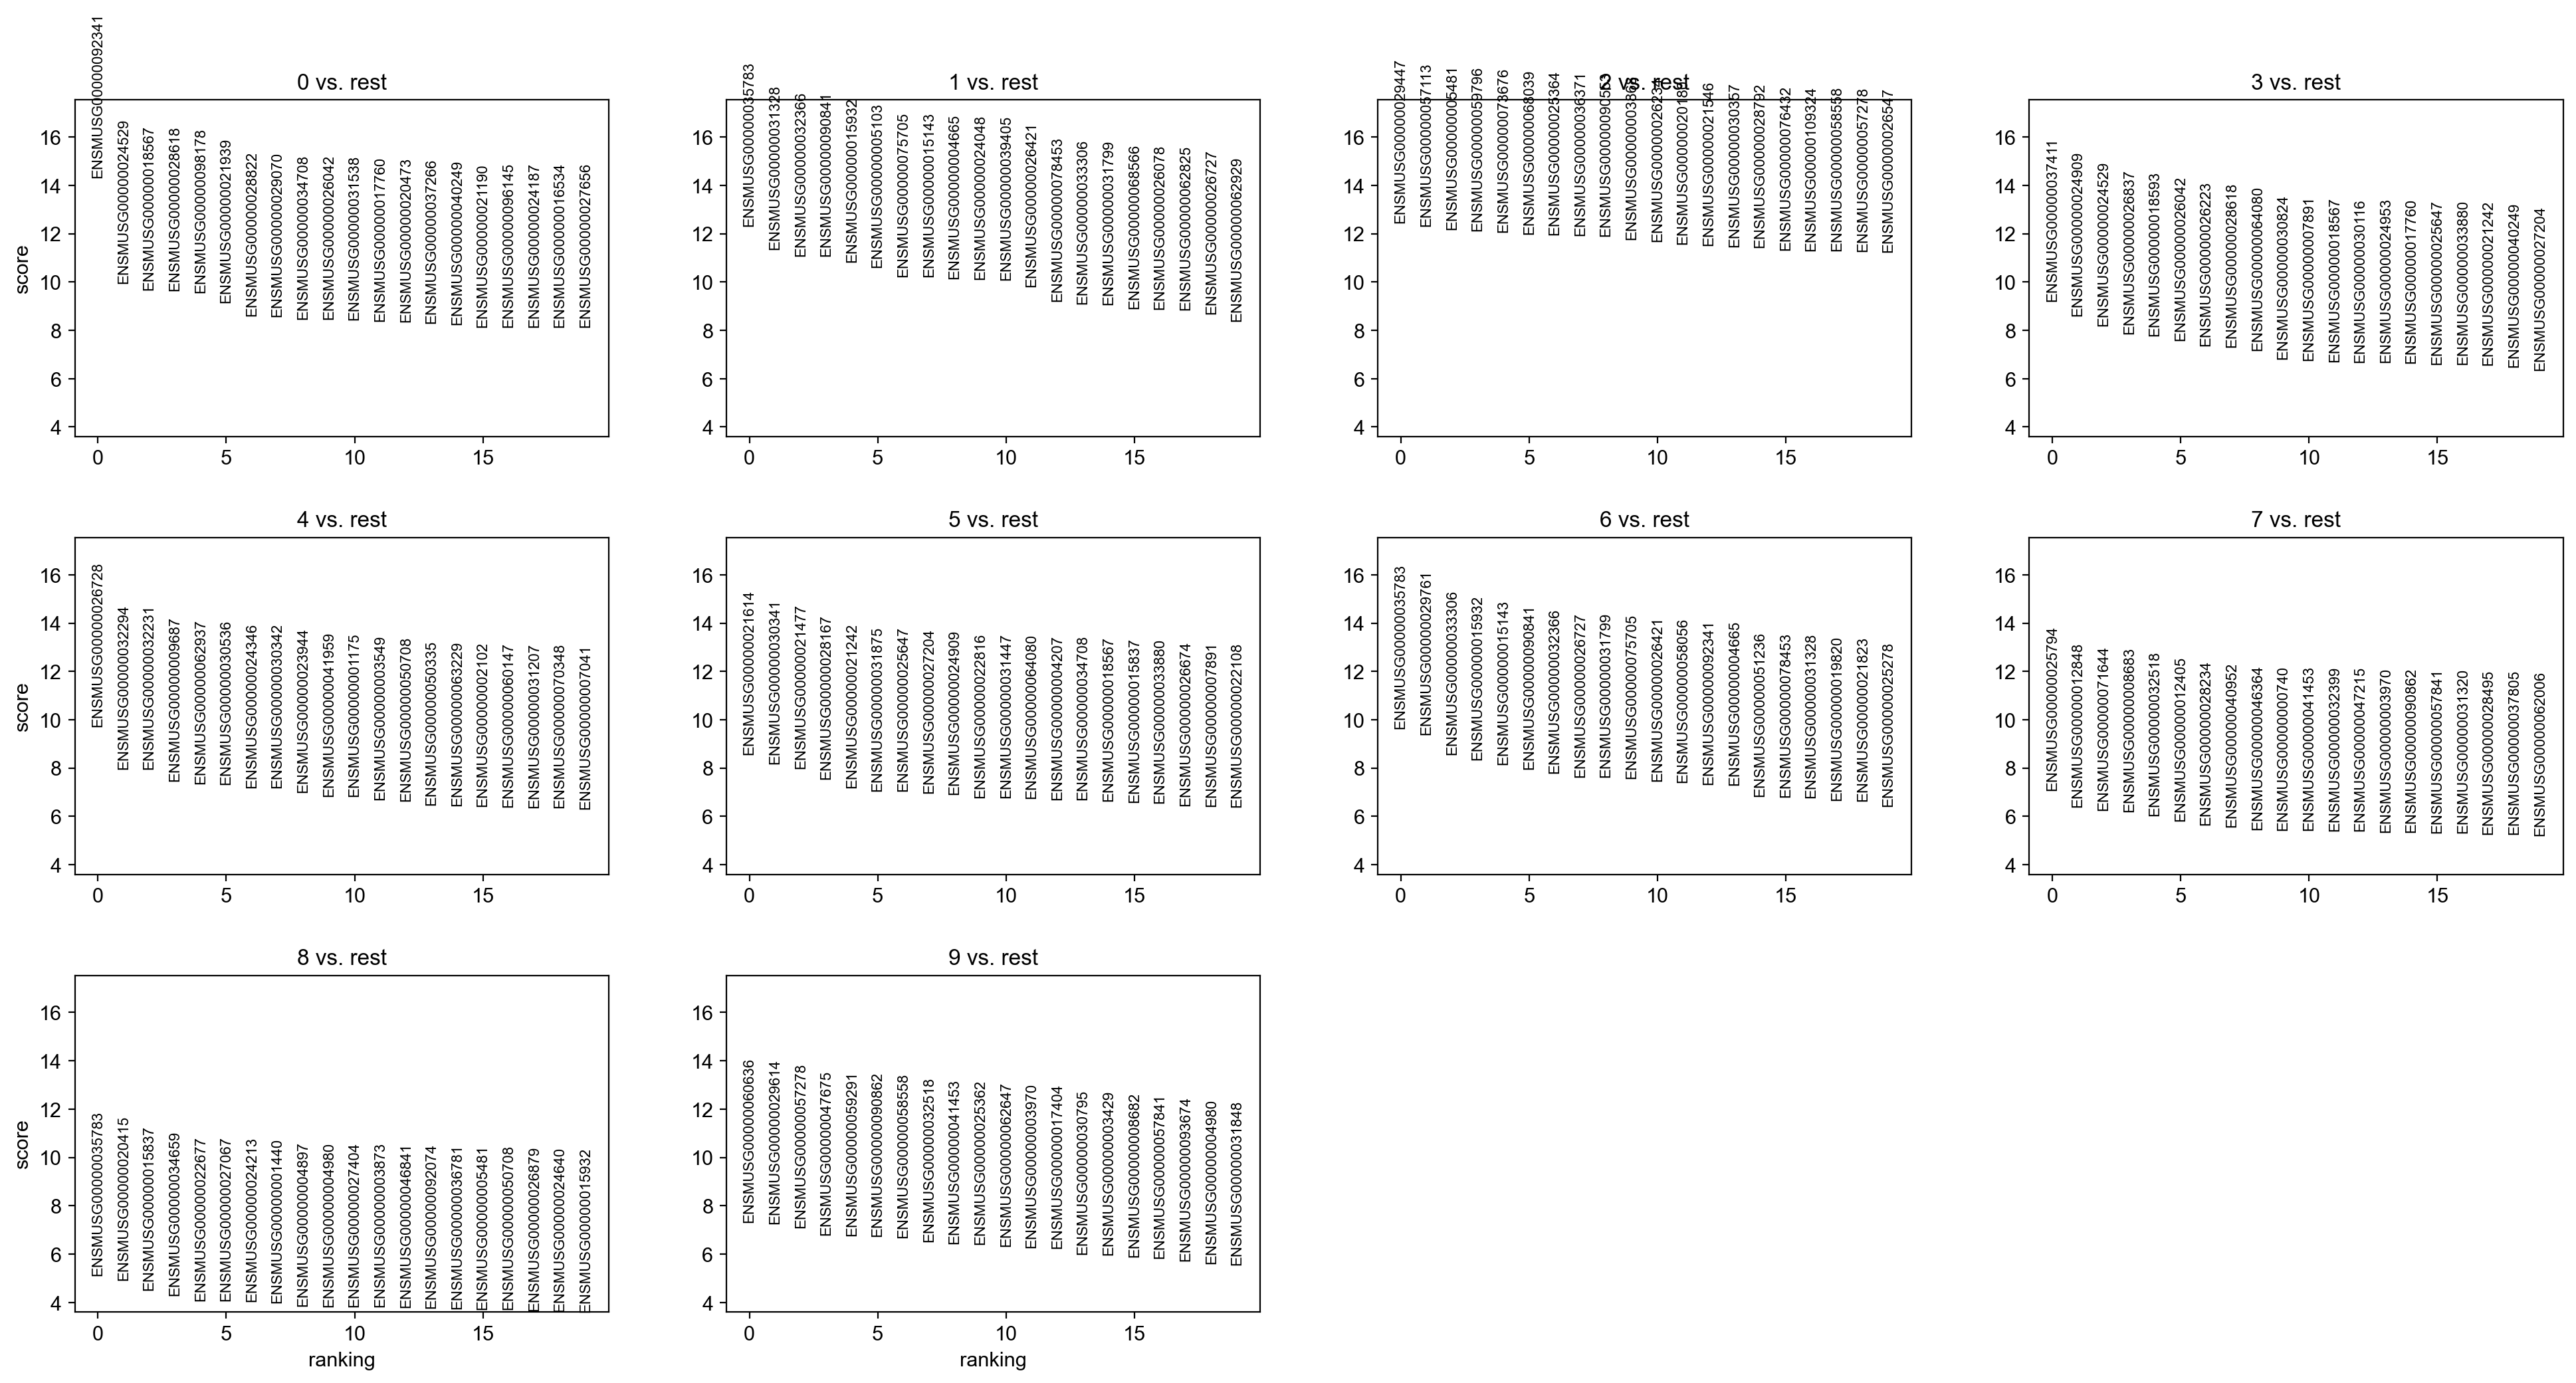

In [50]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
# to visualize the results
sc.pl.rank_genes_groups(adata)

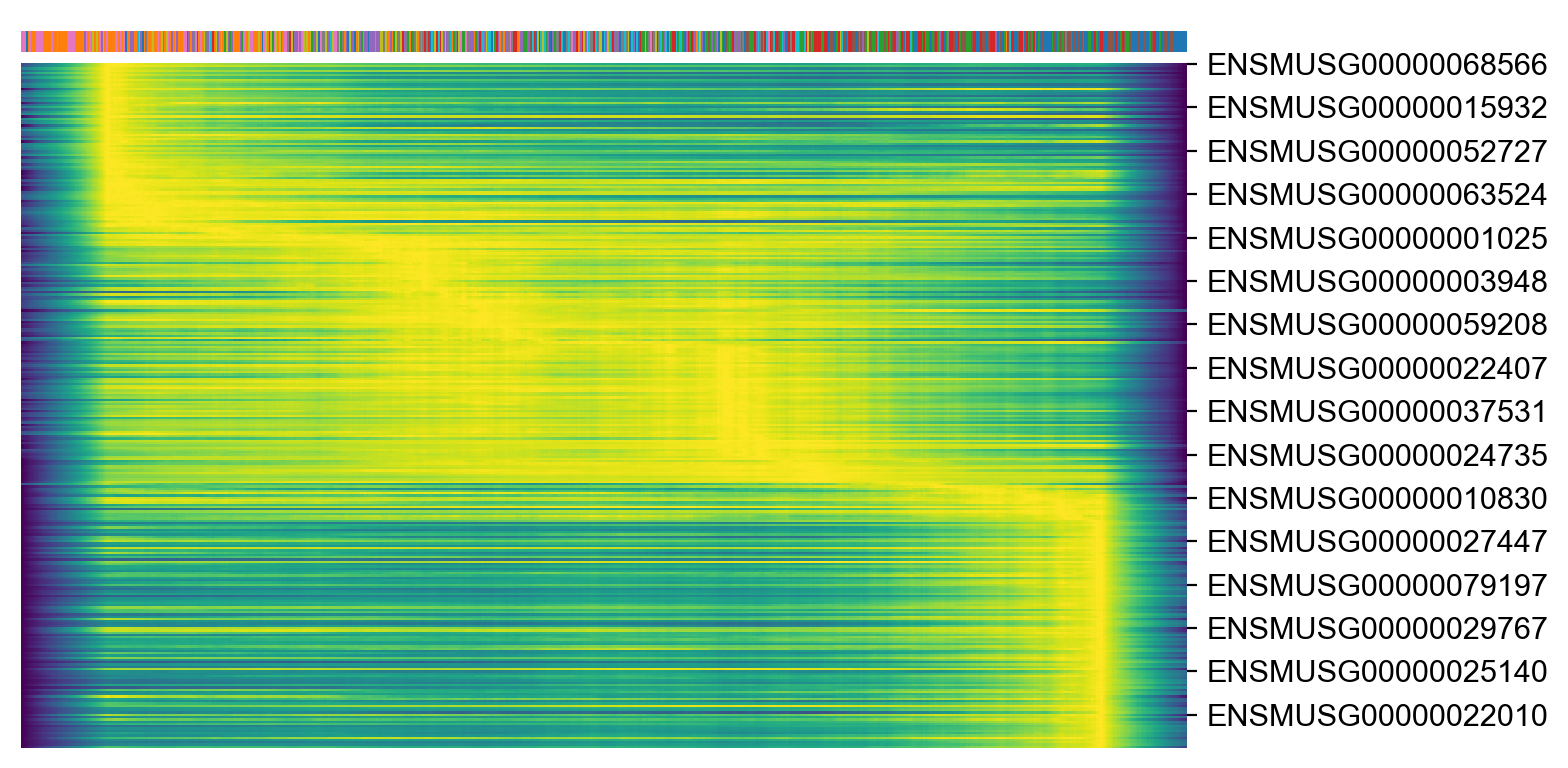

In [51]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', col_color='leiden', n_convolve=100)

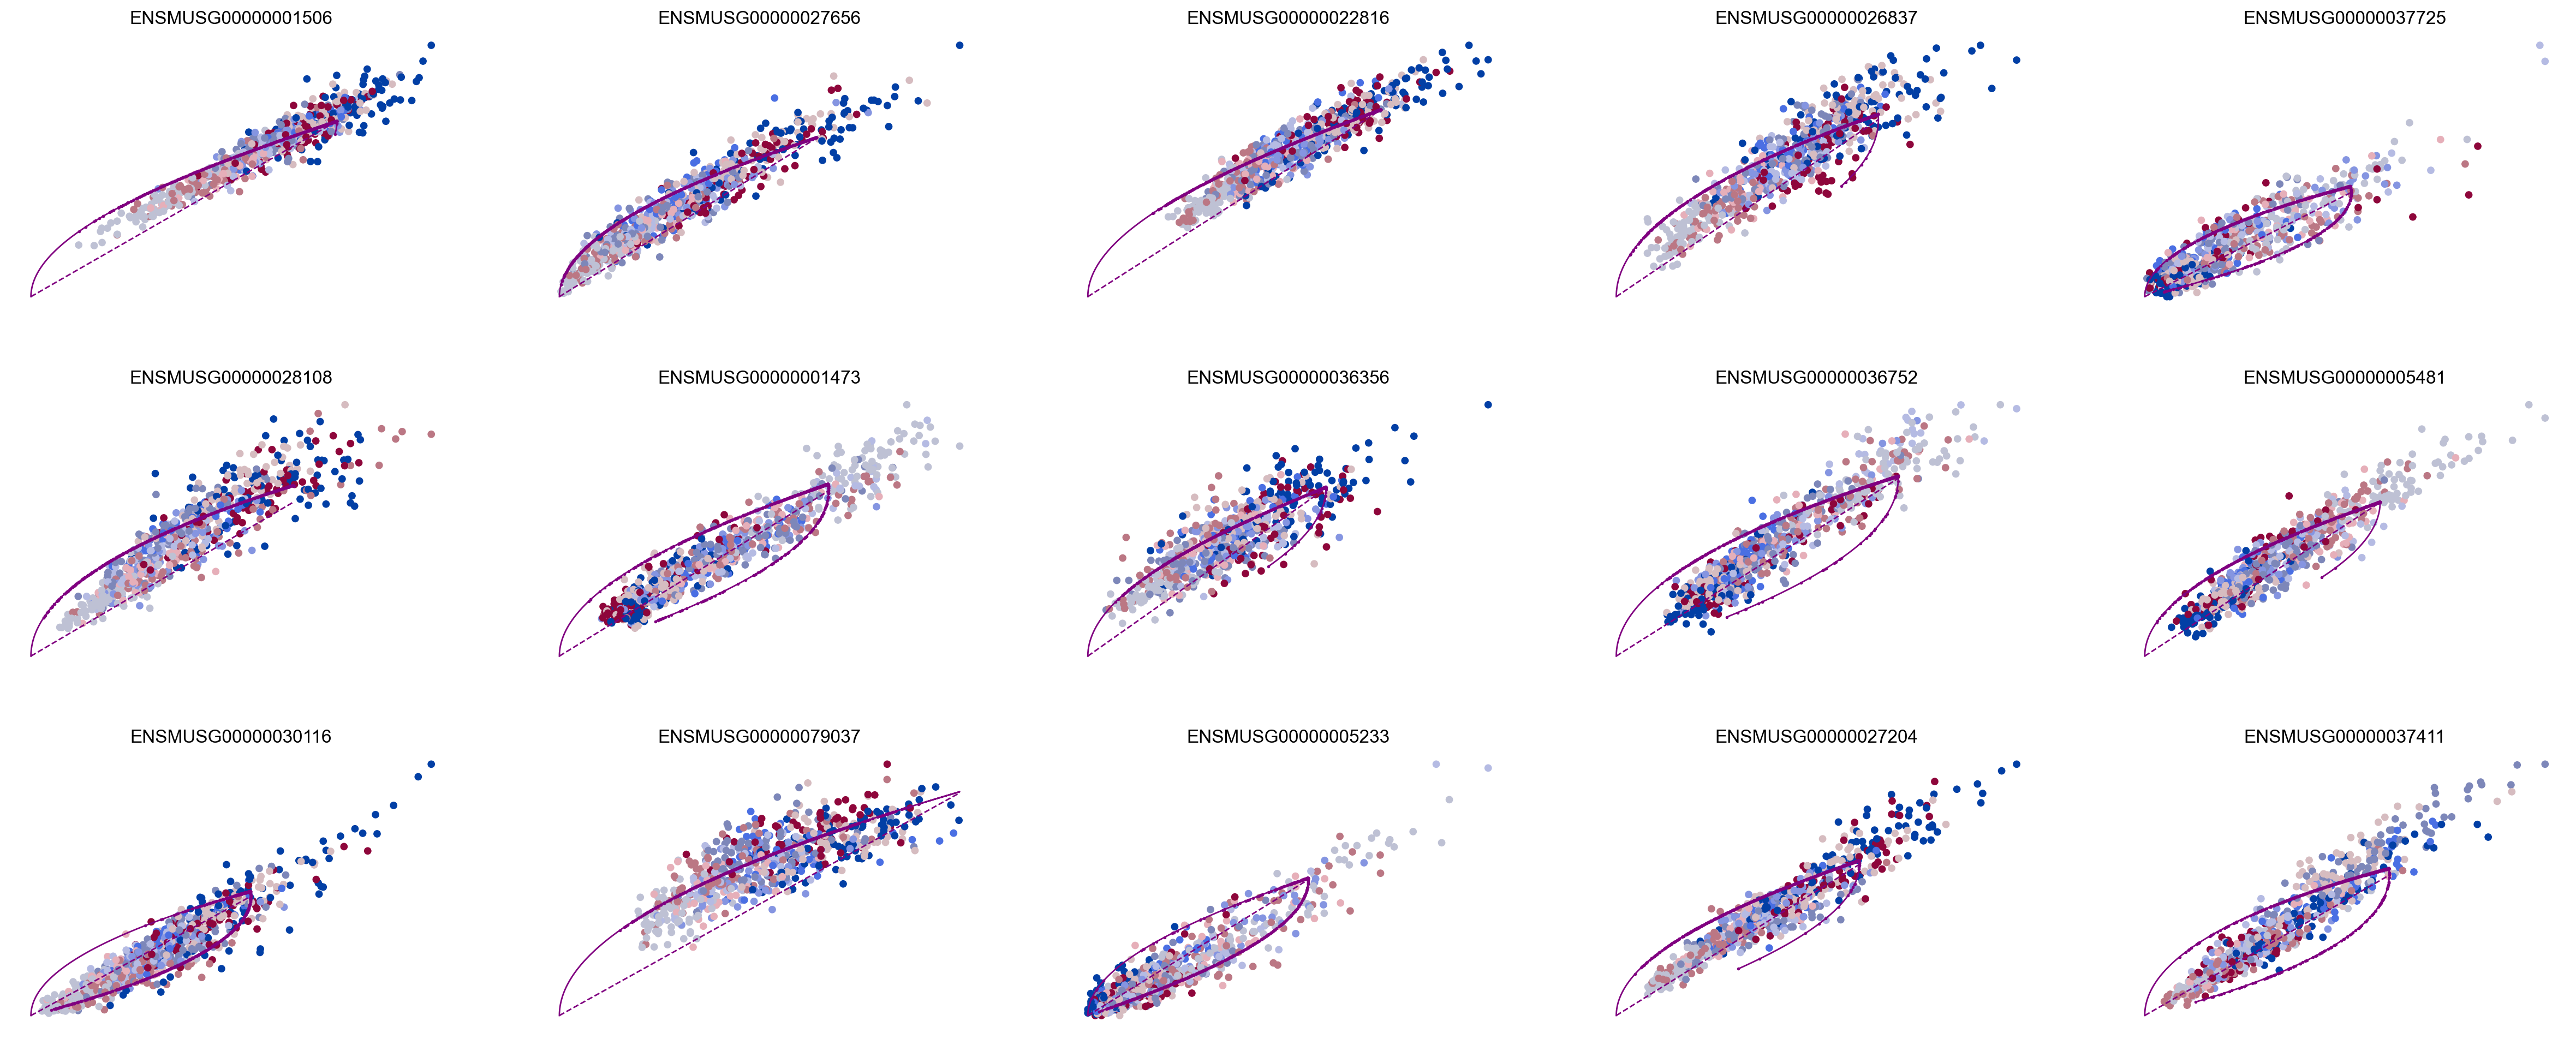

In [52]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:15], ncols=5, frameon=False)

In [53]:
# cluster specific
scv.tl.rank_dynamical_genes(adata, groupby='leiden')
df3 = scv.get_df(adata, 'rank_dynamical_genes/names')
df3.head(5)

0                   1                   2  \
0  ENSMUSG00000079037  ENSMUSG00000001506  ENSMUSG00000001506   
1  ENSMUSG00000036992  ENSMUSG00000022816  ENSMUSG00000079037   
2  ENSMUSG00000020044  ENSMUSG00000027656  ENSMUSG00000050335   
3  ENSMUSG00000005481  ENSMUSG00000028108  ENSMUSG00000024909   
4  ENSMUSG00000001473  ENSMUSG00000018567  ENSMUSG00000057530   

                    3                   4                   5  \
0  ENSMUSG00000022816  ENSMUSG00000001506  ENSMUSG00000001506   
1  ENSMUSG00000027656  ENSMUSG00000022816  ENSMUSG00000027656   
2  ENSMUSG00000001506  ENSMUSG00000079037  ENSMUSG00000021939   
3  ENSMUSG00000026223  ENSMUSG00000005481  ENSMUSG00000022816   
4  ENSMUSG00000028108  ENSMUSG00000027204  ENSMUSG00000005481   

                    6                   7                   8  \
0  ENSMUSG00000001506  ENSMUSG00000001506  ENSMUSG00000001506   
1  ENSMUSG00000027656  ENSMUSG00000027656  ENSMUSG00000022816   
2  ENSMUSG00000022816  ENSMUSG00000063229  ENSMUSG00000079037   
3  ENSMUSG00000026837  ENSMUSG00000018567  ENSMUSG00000028108   
4  ENSMUSG00000028792  ENSMUSG00000022816  ENSMUSG00000027656   

                    9  
0  ENSMUSG00000063229  
1  ENSMUSG00000001506  
2  ENSMUSG00000027656  
3  ENSMUSG00000022816  
4  ENSMUSG00000024909

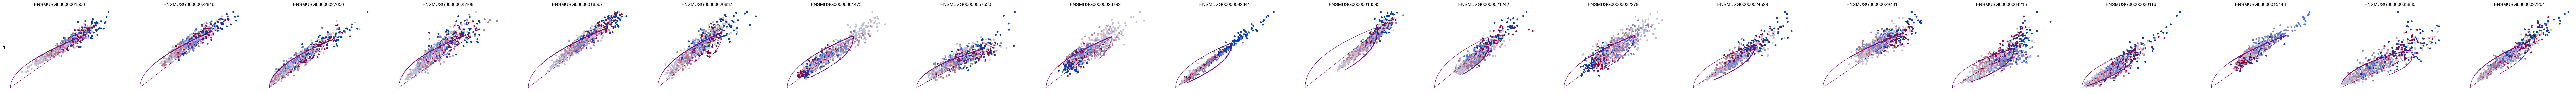

In [54]:
for cluster in ['1']:
    scv.pl.scatter(adata, df3[cluster][:20], ylabel=cluster, frameon=False)

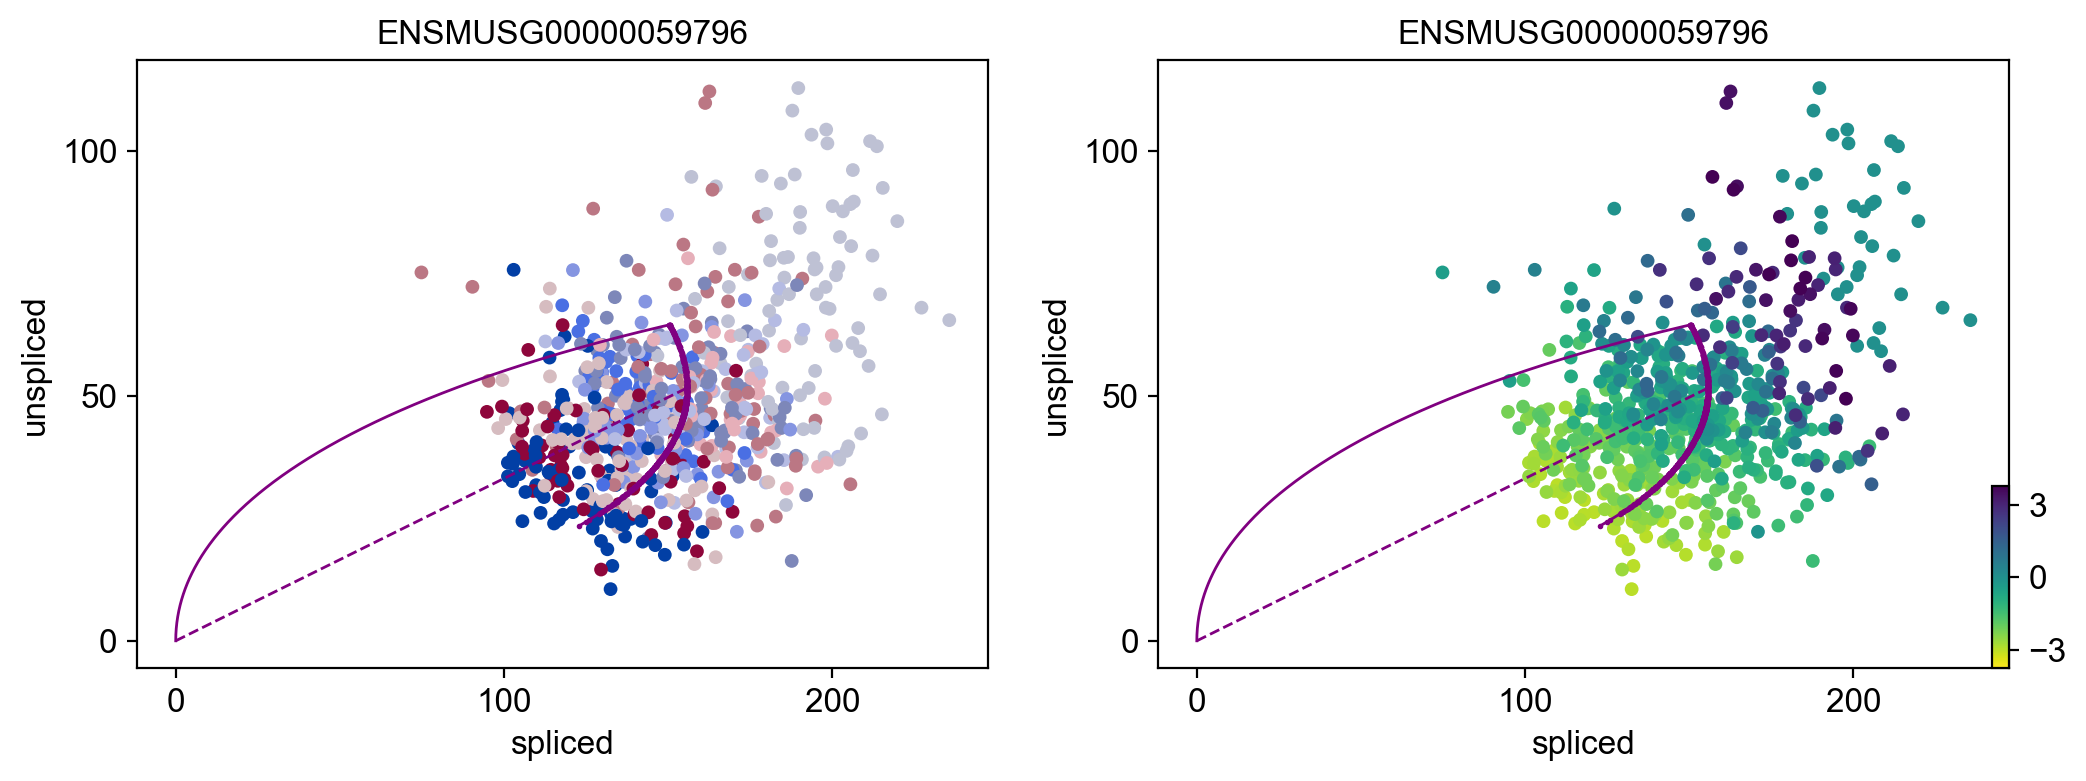

In [55]:
scv.pl.scatter(adata, 'ENSMUSG00000059796', color=['clusters', 'velocity'])

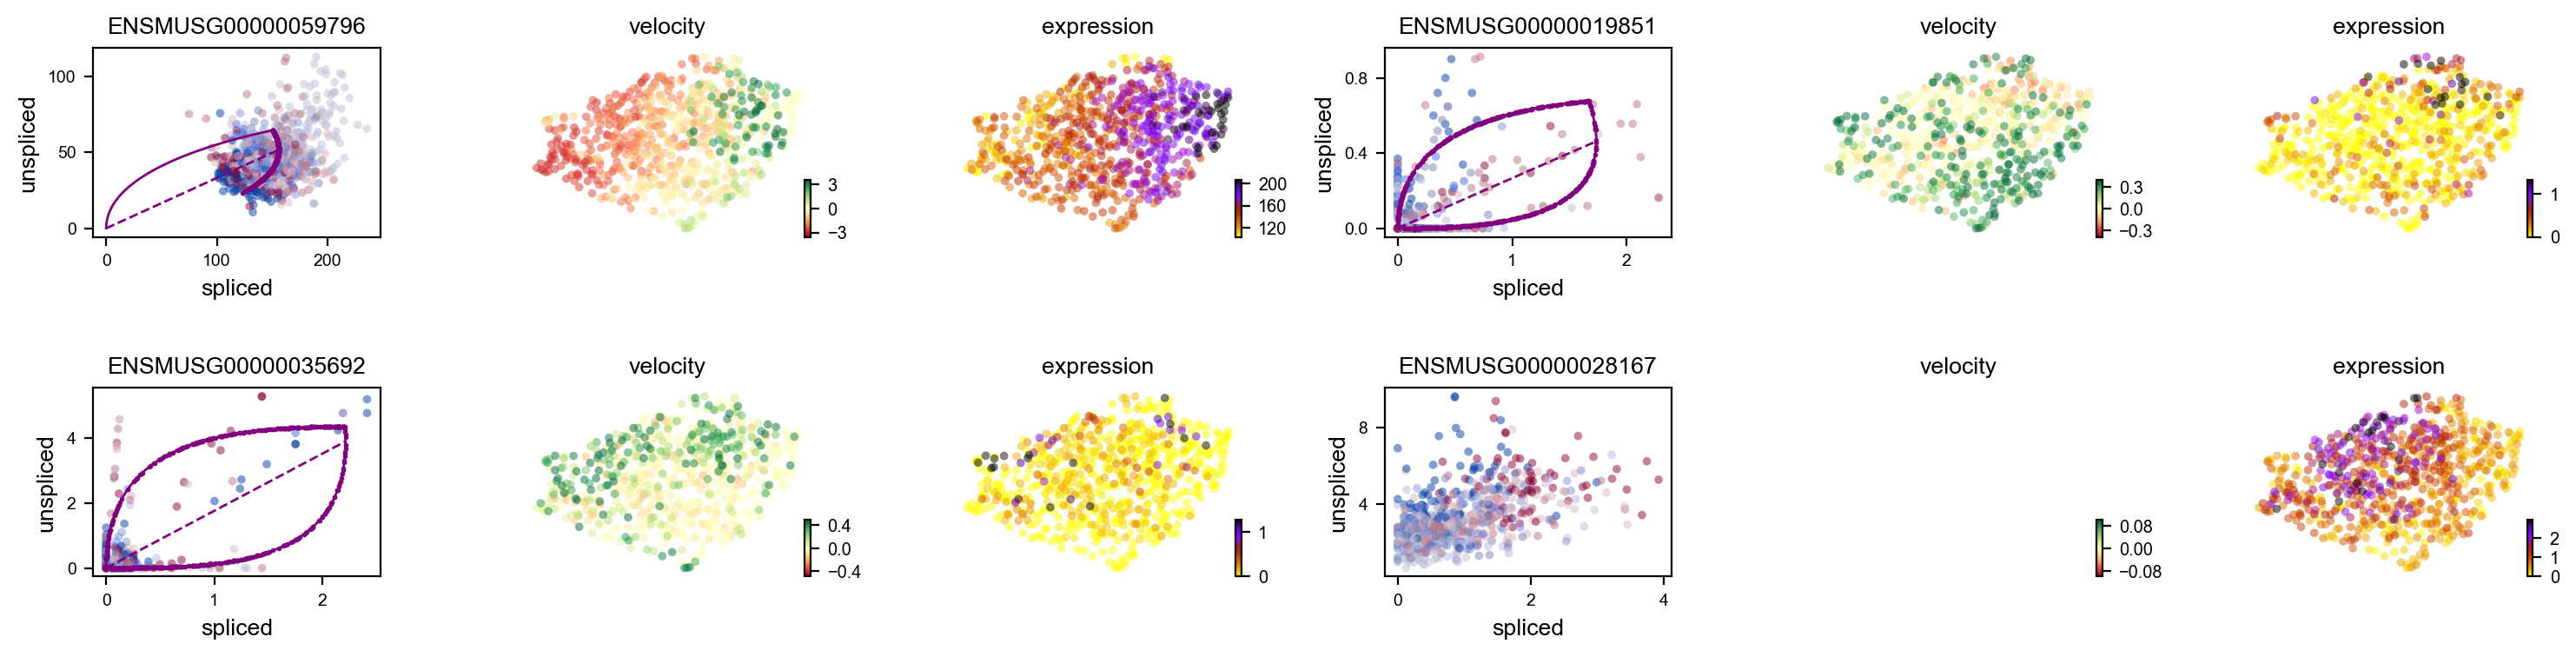

In [56]:
scv.pl.velocity(adata, ['ENSMUSG00000059796',  'ENSMUSG00000019851', 'ENSMUSG00000035692', 'ENSMUSG00000028167'], ncols=2)

In [57]:
count = 1
for x in df_test.index:
    if x in adata.var.index:
        scv.pl.scatter(adata, x, color=['clusters'], save=f"data/UMI_ratio_figures/fig_{x}_normalized.pdf", 
                       xlabel='C57', ylabel='CAST', title=f"{x} (Normalized Data)",
                       show=False)
        count += 1

saving figure to file data/UMI_ratio_figures/fig_ENSMUSG00000001131_normalized.pdf
saving figure to file data/UMI_ratio_figures/fig_ENSMUSG00000008682_normalized.pdf
saving figure to file data/UMI_ratio_figures/fig_ENSMUSG00000031320_normalized.pdf
saving figure to file data/UMI_ratio_figures/fig_ENSMUSG00000031375_normalized.pdf
saving figure to file data/UMI_ratio_figures/fig_ENSMUSG00000044533_normalized.pdf


In [58]:
for x in df_test2.index:
    if x in adata.var.index:
        scv.pl.scatter(adata, x, color=['clusters'], save=f"data/UMI_ratio_figures/fig_{x}_normalized.pdf", 
                       xlabel='C57', ylabel='CAST', title=f"{x} (Normalized Data)",
                       show=False)
        count += 1

saving figure to file data/UMI_ratio_figures/fig_ENSMUSG00000081094_normalized.pdf
saving figure to file data/UMI_ratio_figures/fig_ENSMUSG00000098178_normalized.pdf


In [59]:
adata.write("data/with_ratio.h5ad")

In [60]:
df.to_csv("data/ratios.csv")